## Exploratory Data Analysis - Anti Cancer Peptides

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Bio
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from scipy.stats import pearsonr
import os

%matplotlib inline

Allow multiple outputs from each cell.

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Load in train and test datasets.

In [3]:
df_train = pd.read_csv("../data/acp/train_data.csv")
df_test = pd.read_csv("../data/acp/test_data.csv")

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

train_per = round(100*(df_train.shape[0]/(df_train.shape[0]+df_test.shape[0])))
print(f"Train-test split: {train_per}% Train, {100-train_per}% Test")

Train dataset shape: (1378, 2)
Test dataset shape: (344, 2)
Train-test split: 80% Train, 20% Test


Take a look at the format of the data.

In [4]:
df_train.head()
df_train.dtypes
print(f"Unique values of label: {df_train.label.unique()}")

,sequences,label
0,RRWWRRWRRW,0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1
3,GLFDVIKKVAAVIGGL,1
4,VAKLLAKLAKKVL,1


sequences    object
label         int64
dtype: object

Unique values of label: [0 1]


Check for distribution of classes to identify potential imbalances.

In [5]:
df_train.label.value_counts()
df_test.label.value_counts()
print("Both train and test datasets are perfectly balanced between the positive and negative class")

0    689
1    689
Name: label, dtype: int64

0    172
1    172
Name: label, dtype: int64

Both train and test datasets are perfectly balanced between the positive and negative class


Check if any leading or trailing white spaces present in sequences

In [6]:
len_train = df_train.sequences.apply(len)
len_train_2 = df_train.sequences.str.strip().apply(len)

len_test = df_test.sequences.apply(len)
len_test_2 = df_test.sequences.str.strip().apply(len)

In [7]:
np.where(len_train != len_train_2)
np.where(len_test != len_test_2)

(array([], dtype=int64),)

(array([], dtype=int64),)

No white spaces present in sequences

### Sequence Sizes

Visualizing the distribution of the lengths of sequences in each dataset.

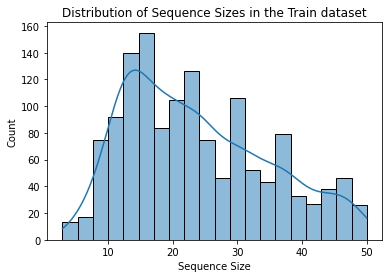

In [8]:
sns.histplot(df_train.sequences.str.len(), bins=20, kde=True);
plt.xlabel("Sequence Size");
plt.title('Distribution of Sequence Sizes in the Train dataset');

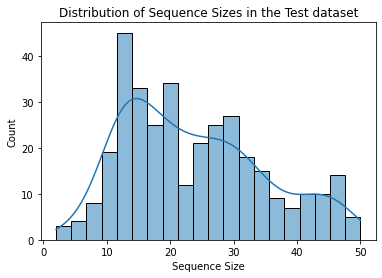

In [9]:
sns.histplot(df_test.sequences.str.len(), bins=20, kde=True);
plt.xlabel("Sequence Size");
plt.title('Distribution of Sequence Sizes in the Test dataset');

In [10]:
train_seq_sizes = df_train.sequences.str.len()
test_seq_sizes = df_test.sequences.str.len()

print(f"Train dataset - mean of sequence sizes: {train_seq_sizes.mean()}")
print(f"Test dataset - mean of sequence sizes: {test_seq_sizes.mean()}")

print(f"Train dataset - smallest sequence size: {train_seq_sizes.min()}")
print(f"Test dataset - smallest sequence size: {test_seq_sizes.min()}")

print(f"Train dataset - largest sequence size: {train_seq_sizes.max()}")
print(f"Test dataset - largest sequence size: {test_seq_sizes.max()}")

Train dataset - mean of sequence sizes: 23.826560232220608
Test dataset - mean of sequence sizes: 23.75872093023256
Train dataset - smallest sequence size: 3
Test dataset - smallest sequence size: 2
Train dataset - largest sequence size: 50
Test dataset - largest sequence size: 50


### Checking for Duplicates

Making sure there are no duplicate proteins.

In [11]:
df_train.sequences.duplicated().sum()
df_test.sequences.duplicated().sum()

0

0

## Feature Engineering - Protein Features

In [12]:
def add_protein_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # Make protein analysis object for each sequence
    df["protein_analysis"] = df["sequences"].map(ProteinAnalysis)

    # Extract protein features from analysis object column
    df["amino_acid_count"] = df["protein_analysis"].apply(lambda x: x.count_amino_acids())
    df["amino_acid_percent"] = df["protein_analysis"].apply(lambda x: x.get_amino_acids_percent())
    df["molecular_weight"] = df["protein_analysis"].apply(lambda x: x.molecular_weight())
    df["aromaticity"] = df["protein_analysis"].apply(lambda x: x.aromaticity())
    df["instability_index"] = df["protein_analysis"].apply(lambda x: x.instability_index())
    df["flexibility"] = df["protein_analysis"].apply(lambda x: x.flexibility())
    df["gravy"] = df["protein_analysis"].apply(lambda x: x.gravy())
    df["isoelectric_point"] = df["protein_analysis"].apply(lambda x: x.isoelectric_point())
    df["charge_at_pH"] = df["protein_analysis"].apply(lambda x: x.charge_at_pH(7.4)) # average pH in body

    # Create three columns for helix, turn, and sheet from secondary structure fraction
    df["helix_frac"] = df["protein_analysis"].apply(lambda x: x.secondary_structure_fraction()[0])
    df["turn_frac"] = df["protein_analysis"].apply(lambda x: x.secondary_structure_fraction()[1])
    df["sheet_frac"] = df["protein_analysis"].apply(lambda x: x.secondary_structure_fraction()[2])

    # Get mean of molar extinction coefficients
    df["molar_extinction_coefficient"] = df["protein_analysis"].apply(lambda x: np.mean(x.molar_extinction_coefficient()))

    # Convert percentages in decimal form to percent form
    df["amino_acid_percent"] = df["amino_acid_percent"].apply(lambda x: {key: 100*val for key, val in x.items()})

    # Convert flexibility arrays into mean flexibility to get a single value, unless empty array, in which case replace with 0
    df["flexibility"] = df["flexibility"].apply(lambda x: np.mean(x) if (x != []) else 0)
    
    # Drop protein analysis object column
    df = df.drop("protein_analysis", axis=1)

    return df

In [13]:
# Add protein features as columns
df_train = add_protein_features(df_train)
df_test = add_protein_features(df_test)

In [14]:
df_train.head()

,sequences,label,amino_acid_count,amino_acid_percent,molecular_weight,aromaticity,instability_index,flexibility,gravy,isoelectric_point,charge_at_pH,helix_frac,turn_frac,sheet_frac,molar_extinction_coefficient
0,RRWWRRWRRW,0,"{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...","{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0, 'F': ...",1699.9691,0.400000,352.680000,0.967143,-3.060000,11.999968,5.557302,0.400000,0.000000,0.000000,22000.0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0,"{'A': 2, 'C': 0, 'D': 1, 'E': 0, 'F': 1, 'G': ...","{'A': 7.6923076923076925, 'C': 0.0, 'D': 3.846...",2816.3054,0.115385,22.946154,1.011433,-0.230769,10.295295,4.579467,0.346154,0.230769,0.192308,6990.0
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1,"{'A': 8, 'C': 0, 'D': 1, 'E': 0, 'F': 0, 'G': ...","{'A': 23.52941176470588, 'C': 0.0, 'D': 2.9411...",3455.0584,0.029412,1.847059,0.998206,0.185294,10.001706,2.634853,0.205882,0.147059,0.441176,5500.0
3,GLFDVIKKVAAVIGGL,1,"{'A': 2, 'C': 0, 'D': 1, 'E': 0, 'F': 1, 'G': ...","{'A': 12.5, 'C': 0.0, 'D': 6.25, 'E': 0.0, 'F'...",1599.9542,0.062500,14.187500,0.994602,1.443750,8.590944,0.552888,0.500000,0.187500,0.250000,0.0
4,VAKLLAKLAKKVL,1,"{'A': 3, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...","{'A': 23.076923076923077, 'C': 0.0, 'D': 0.0, ...",1394.8306,0.000000,-10.361538,1.003571,1.030769,10.477676,3.513128,0.461538,0.000000,0.538462,0.0


In [15]:
df_train.dtypes

sequences                        object
label                             int64
amino_acid_count                 object
amino_acid_percent               object
molecular_weight                float64
aromaticity                     float64
instability_index               float64
flexibility                     float64
gravy                           float64
isoelectric_point               float64
charge_at_pH                    float64
helix_frac                      float64
turn_frac                       float64
sheet_frac                      float64
molar_extinction_coefficient    float64
dtype: object

### Amino Acid Frequencies/Composition

Confirm that 20 amino acids are present in our sequences.

In [16]:
amino_acids = set()
for protein in df_train.sequences:
    for acid in protein:
        amino_acids.add(acid)
print(amino_acids)
print(len(amino_acids))

{'D', 'Y', 'T', 'L', 'E', 'M', 'N', 'K', 'I', 'V', 'A', 'Q', 'H', 'F', 'W', 'S', 'P', 'C', 'G', 'R'}
20


#### Function to get average amino acid content in a series of sequences

In [17]:
def get_avg_amino_acid_count(df: pd.DataFrame, amino_acids: set or list) -> dict:
    # Initialize amino acid dict for all sequences
    am_acid_dict = dict.fromkeys(amino_acids, 0)

    for am_dict in df.amino_acid_count:
        for key in am_dict.keys():
            # If amino acid present in sequence
            if am_dict[key] != 0:
                am_acid_dict[key] = am_acid_dict.get(key) + am_dict[key]

    for key in am_acid_dict.keys():
        am_acid_dict[key] = am_acid_dict.get(key)/len(df_train)

    return am_acid_dict

In [18]:
acp_avg_acids = get_avg_amino_acid_count(df_train[df_train.label==1], amino_acids)
non_acp_avg_acids = get_avg_amino_acid_count(df_train[df_train.label==0], amino_acids)

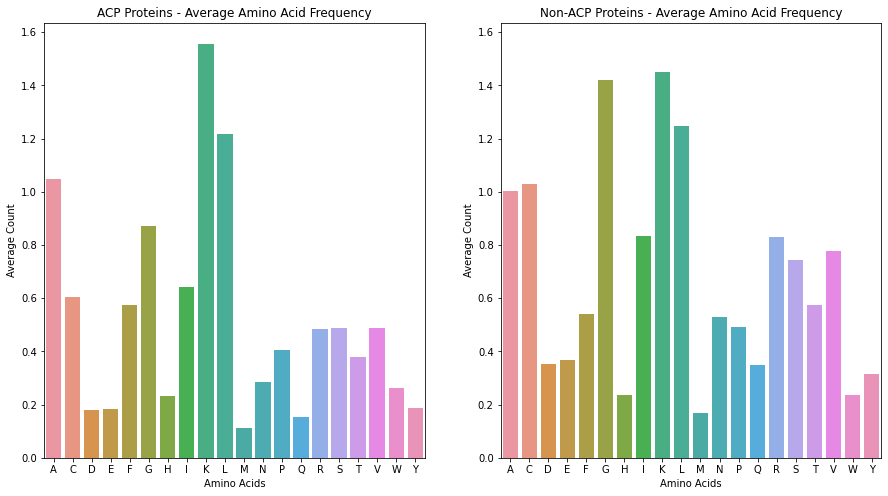

In [19]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(121)
sns.barplot(x = sorted(acp_avg_acids.keys()), 
            y = [acp_avg_acids.get(key) for key in sorted(acp_avg_acids.keys())]).set(
                title='ACP Proteins - Average Amino Acid Frequency');
ax1.set(xlabel='Amino Acids', ylabel='Average Count');

ax2 = plt.subplot(122, sharey=ax1)
sns.barplot(x = sorted(non_acp_avg_acids.keys()), 
            y = [non_acp_avg_acids.get(key) for key in sorted(non_acp_avg_acids.keys())]).set(
                title='Non-ACP Proteins - Average Amino Acid Frequency');
ax2.set(xlabel='Amino Acids', ylabel='Average Count');

In [20]:
pearsonr([acp_avg_acids.get(key) for key in sorted(acp_avg_acids.keys())],
            [non_acp_avg_acids.get(key) for key in sorted(non_acp_avg_acids.keys())])[0]

0.9072315508523577

As seen in both the barplots of and correlation between the amino acid average counts of acp and non-acp proteins, there is very little difference between the two, so this feature likely has very little predictive power for classifying ACPs and non-ACPs. 

In addition, the proteins chosen for this dataset may not be indicative of general trends in amino acid frequency, so we have to take care to be aware of this assumption if using this feature in our models.

#### Function to get average percentage of amino acid for each sequence

In [21]:
def get_avg_amino_acid_percent(df: pd.DataFrame, amino_acids: set or list) -> dict:
    # Initialize amino acid dict for all sequences
    am_acid_dict = dict.fromkeys(amino_acids, 0)

    for am_dict in df.amino_acid_percent:
        for key in am_dict.keys():
            # If amino acid present in sequence
            if am_dict[key] != 0:
                am_acid_dict[key] = am_acid_dict.get(key) + am_dict[key]

    for key in am_acid_dict.keys():
        am_acid_dict[key] = am_acid_dict.get(key)/float(len(df_train))

    return am_acid_dict

In [22]:
# Get average percentage of frequency of each amino acid over all ACP and non-ACP sequences
acp_avg_acids_percent = get_avg_amino_acid_percent(df_train[df_train.label==1], amino_acids)
non_acp_avg_acids_percent = get_avg_amino_acid_percent(df_train[df_train.label==0], amino_acids)

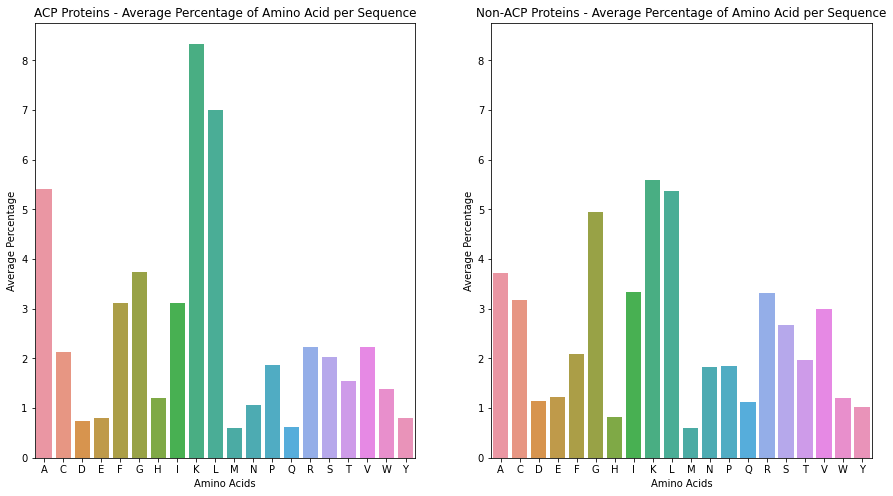

In [23]:
plt.figure(figsize=(15,8))
ax1 = plt.subplot(121)
sns.barplot(x = sorted(acp_avg_acids_percent.keys()), 
            y = [acp_avg_acids_percent.get(key) for key in sorted(acp_avg_acids_percent.keys())]).set(
                title='ACP Proteins - Average Percentage of Amino Acid per Sequence');
ax1.set(xlabel='Amino Acids', ylabel='Average Percentage');
ax2 = plt.subplot(122, sharey=ax1)
sns.barplot(x = sorted(non_acp_avg_acids_percent.keys()), 
            y = [non_acp_avg_acids_percent.get(key) for key in sorted(non_acp_avg_acids_percent.keys())]).set(
                title='Non-ACP Proteins - Average Percentage of Amino Acid per Sequence');
ax2.set(xlabel='Amino Acids', ylabel='Average Percentage');


In [24]:
pearsonr([acp_avg_acids_percent.get(key) for key in sorted(acp_avg_acids_percent.keys())],
            [non_acp_avg_acids_percent.get(key) for key in sorted(non_acp_avg_acids_percent.keys())])[0]

0.89539681075909

As seen in both the barplots of and correlation between the amino acid average percentages per sequence of acp and non-acp proteins, there is very little difference between the two, so this feature likely has very little predictive power for classifying ACPs and non-ACPs. 

In addition, the proteins chosen for this dataset may not be indicative of general trends in amino acid frequency, so we have to take care to be aware of this assumption if using this feature in our models.

### All other Protein Features

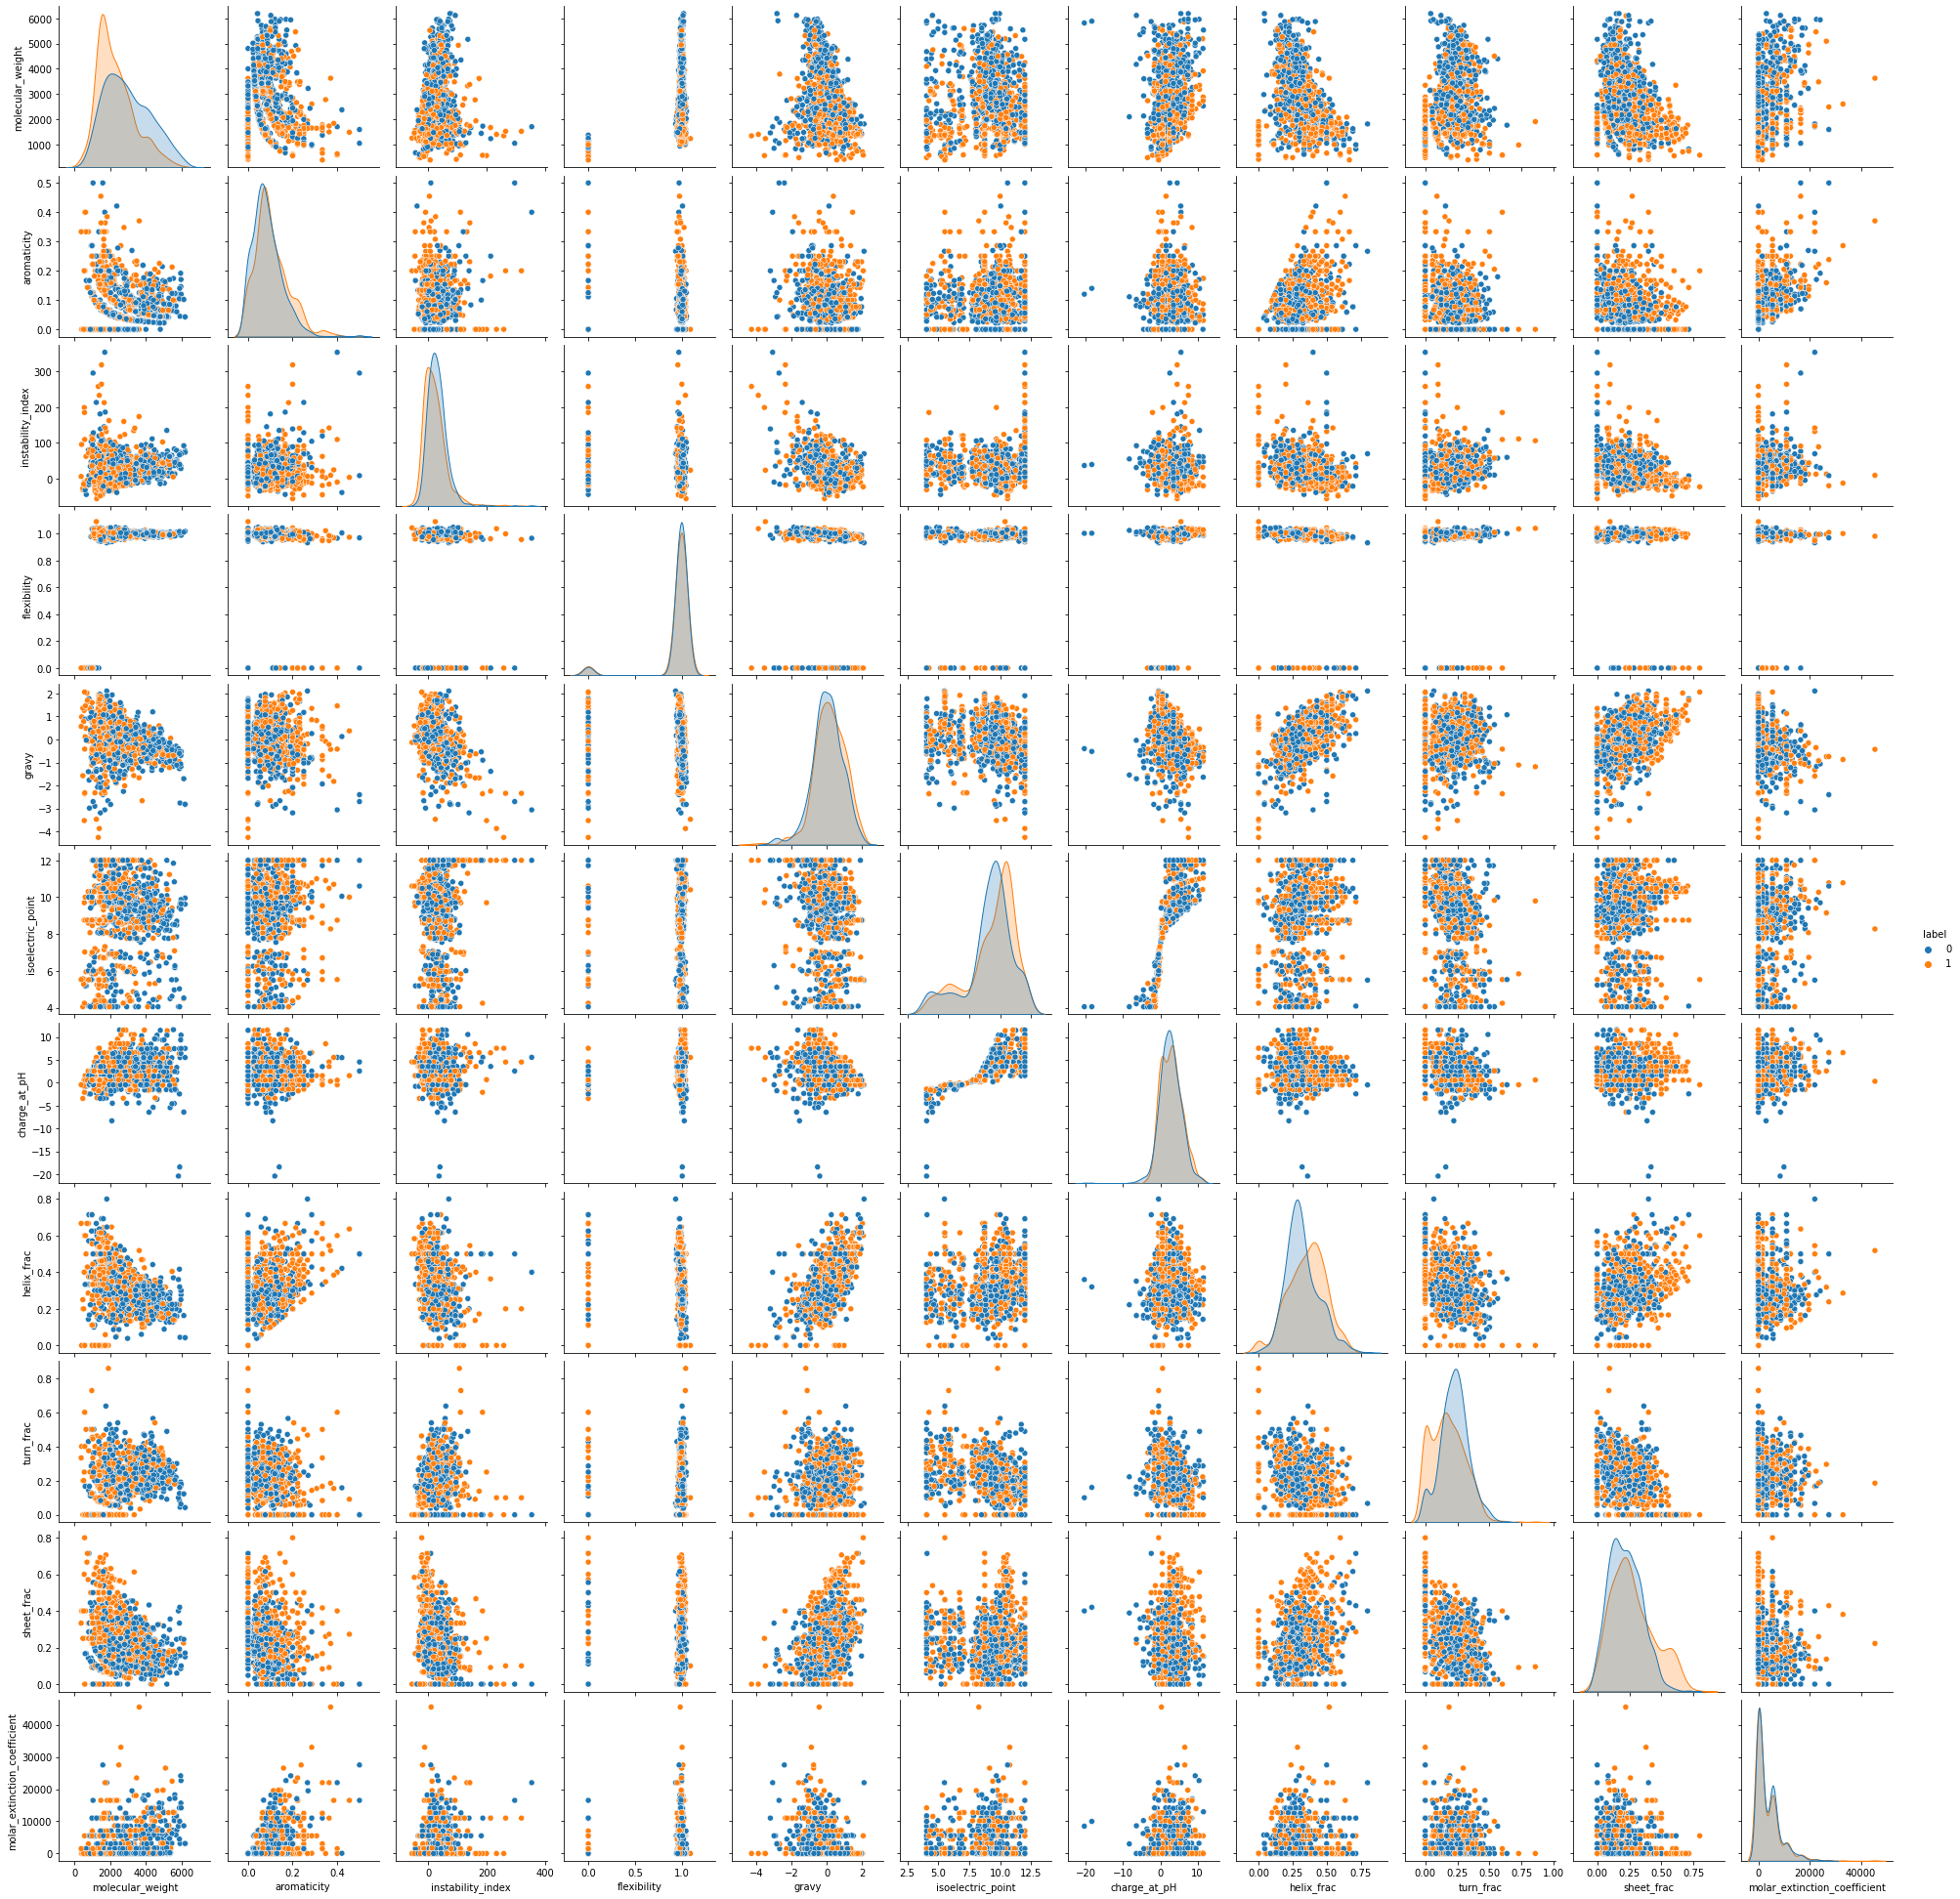

In [25]:
prot_features=["molecular_weight", "aromaticity", "instability_index", "flexibility", "gravy", 
               "isoelectric_point", "charge_at_pH", "helix_frac", "turn_frac", "sheet_frac",
               "molar_extinction_coefficient"]
sns.pairplot(data=df_train, x_vars=prot_features, hue="label")

While there seems to be some separation between ACPs and non-ACPs with regards to these features, the two groups are not well separated by any of these features. It is possible however that a classifier that uses all of these features might perform well.

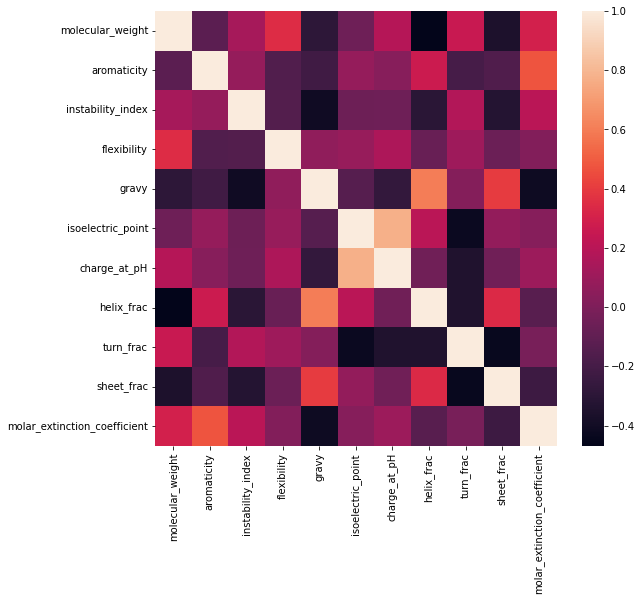

In [26]:
plt.figure(figsize=(9,8))
sns.heatmap(data=df_train[prot_features].corr());

It looks like the only highly correlated features are `charge_at_pH` and `isoelectric_point`. This makes sense, as both refer to a pH value, the first being the charge of the protein at the average human body pH (7.4), and the second as the pH at which no net migration takes place in an electric field.

Since these features are highly correlated, it might be a good idea to remove one of them during modelling to avoid multicollinearity, after checking the variance inflation factor to quantify the severity of multicollinearity. 

In [34]:
df_train.to_csv("../data/acp/train_expanded.csv", index=False)
df_test.to_csv("../data/acp/test_expanded.csv", index=False)

## Alignment

In [37]:
import Bio
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [38]:
sequences = df_train.copy()
sequences.drop(df_train.columns.difference(["sequences", "label"]), axis=1, inplace=True)
sequences.head()

,sequences,label
0,RRWWRRWRRW,0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1
3,GLFDVIKKVAAVIGGL,1
4,VAKLLAKLAKKVL,1


In [39]:
# Demonstrate pairwise alignment 
for idx, prot_1 in enumerate(sequences.sequences[:3]):
    sim_seq = None
    max_score = 0
    alignment = None
    for prot_2 in sequences.sequences.drop(idx):
        alignments = pairwise2.align.globalxx(prot_1, prot_2)
        score = int(format_alignment(*alignments[0]).split("Score=")[1].rstrip())
        if score > max_score:
            max_score = score
            sim_seq = prot_2
            alignment = format_alignment(*alignments[0])
    print(max_score, sim_seq)
    print(alignment)

8 GRRRSVQWCAVSQPEATKCFQWQRNMRKVRGPPVSCIKRDSPIQCIQA
-RR----W-------------W-R--RW--R--------RW---------
 ||    |             | |  |   |        |          
GRRRSVQWCAVSQPEATKCFQWQRNMR-KVRGPPVSCIKR-DSPIQCIQA
  Score=8

16 GWRTLLKKAEVKTVGKLALKHYL
GWKSVFRKA---KK--VGKTVGG-LALD-HYLG
||    |     ||  | ||| | |||  ||| 
GW----R--TLLKKAEV-KTV-GKLAL-KHYL-
  Score=16

31 ALWKTMLKKLGTVALHAGKAALGAAADTISQGA
ALWKTMLKKLGTM-ALHAGKAALGAAADTISQGTQ-
||||||||||||  |||||||||||||||||||   
ALWKTMLKKLGT-VALHAGKAALGAAADTISQG--A
  Score=31



In [40]:
# def add_alignment_seq_and_score(df: pd.DataFrame):
#     df = df.copy()

#     # Initialize alignment columns
#     df["aligned_seq"] = pd.Series(None, index=df.index, dtype='object')
#     df["align_score"] = pd.Series(0, index=df.index, dtype='int')

#     # Iterate through each sequence and do a pairwise alignment between every other sequence
#     for idx, prot_1 in enumerate(df.sequences):
#         sim_seq = None
#         max_score = 0
#         for prot_2 in sequences.sequences.drop(idx):
#             alignments = pairwise2.align.globalxx(prot_1, prot_2)
#             score = int(format_alignment(*alignments[0]).split("Score=")[1].rstrip())
#             if score > max_score:
#                 max_score = score
#                 sim_seq = prot_2
#         df.loc[idx, "aligned_seq"] = sim_seq
#         df.loc[idx, "align_score"] = max_score
    
#     return df

In [41]:
# # Using if-else block to avoid long runtime of this function
# if not os.path.isfile("../data/acp/train_expanded.csv"):
#     df_tr_align = add_alignment_seq_and_score(df_train)
#     df_tr_align.to_csv("../data/acp/train_expanded.csv")
# else:
#     df_tr_align = pd.read_csv("../data/acp/train_expanded.csv")

In [42]:
# if not os.path.isfile("../data/acp/test_expanded.csv"):
#     df_t_align = add_alignment_seq_and_score(df_test)
#     df_t_align.to_csv("../data/acp/test_expanded.csv")
# else:
#     df_t_align = pd.read_csv("../data/acp/test_expanded.csv")

In [43]:
# df_tr_align.align_score.describe()

In [44]:
# df_tr_align[["sequences", "aligned_seq", "align_score"]].head()

In [45]:
# sns.histplot(data=df_tr_align, x="align_score");

In [46]:
# df_tr_align["percent_align"] = df_tr_align.align_score/df_tr_align.sequences.apply(len)
# df_tr_align[["sequences", "aligned_seq", "align_score", "percent_align"]].head()

# df_t_align["percent_align"] = df_t_align.align_score/df_t_align.sequences.apply(len)
# df_t_align[["sequences", "aligned_seq", "align_score", "percent_align"]].head()

In [47]:
# sns.histplot(data=df_tr_align, x="percent_align");

In [48]:
# df_tr_align.percent_align.describe()

In [59]:
# from Bio.Align import substitution_matrices
# substitution_matrix = substitution_matrices.load("BLOSUM62")

In [49]:
# for idx in df_tr_align.index:
#     df_tr_align.loc[idx, "BLOSUM62_score"] = pairwise2.align.globaldx(df_tr_align.loc[idx, "sequences"], 
#                                                 df_tr_align.loc[idx, "aligned_seq"], substitution_matrix, score_only=True)

In [50]:
# df_tr_align[["sequences", "aligned_seq", "align_score", "BLOSUM62_score"]].head()

In [51]:
# for idx in df_t_align.index:
#     df_t_align.loc[idx, "BLOSUM62_score"] = pairwise2.align.globaldx(df_t_align.loc[idx, "sequences"], 
#                                                 df_t_align.loc[idx, "aligned_seq"], substitution_matrix, score_only=True)
  

In [52]:
# df_t_align[["sequences", "aligned_seq", "align_score", "BLOSUM62_score"]].head()

In [53]:
# df_tr_align.to_csv("../data/acp/train_expanded.csv")
# df_t_align.to_csv("../data/acp/test_expanded.csv")

### Investigating cross-similarity scores

In [54]:
# alignment_temp = pairwise2.align.globalxx(df_tr_align.sequences.loc[4], df_tr_align.sequences.loc[9], score_only=True)

In [55]:
cross_df_tr = pd.DataFrame(index=df_train.sequences, columns=df_train.sequences)
cross_df_tr.head()

cross_df_t = pd.DataFrame(index=df_test.sequences, columns=df_test.sequences)
cross_df_t.head()

sequences,RRWWRRWRRW,GWKSVFRKAKKVGKTVGGLALDHYLG,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,GLFDVIKKVAAVIGGL,VAKLLAKLAKKVL,IIGHLIKTALGFLGL,FLPLLASLFSRLL,WFKKIPKFLHLAKKF,ATCDLLSKWNWNHTACAGHCIAKGFKGGYCNDKAVCVCRN,NIPQLTPTP,...,LLGDFFRKAKEKIGKEFKRIVQR,FLSAITSLLGKLL,KAFWGLQH,GIFNVFKGALKTAGKHVAGSLLNQLKCKVSGEC,GLMDMVKGAAKNLFASALDTLKCKITGC,LLKLLKWLLKLLK,GFKDWIKGAAKKLIKTVAANIANQ,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,FISAIASFLGKFL,RLSRIVVIRVCR
sequences,,,,,,,,,,,,,,,,,,,,,
RRWWRRWRRW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GWKSVFRKAKKVGKTVGGLALDHYLG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GLFDVIKKVAAVIGGL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VAKLLAKLAKKVL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sequences,FLPLLLSALPSFLCLVFKKC,DKLIGSCVWLAVNYTSNCNAECKRRGYKGGHCGSFLNVNCWCET,AVKDTYSCFIMRGKCRHECHDFEKPIGFCTKLNANCYM,GLPTCGETCFGGTCNTPGCTCDPWPVCTHN,ENCGRQAG,GVLDAFRKIATVVKNVV,VAKKFAKKFKKFAKKFAKFAFAF,GIGKFLHSAKKWGKAFVGQIMNC,ALWKNMLKGIGKLAGKAALGAVKKLVGAES,FFPIVGKLLFGLSGLL,...,ILGPVISTIGGVLGGLLKNL,PEWFKCRRWQWRMKKLGA,GFLDTFKNLALNAAKSAGVSVLNSLSCKLFKTC,SGKLWWRRKK,CAHNLTHAC,LLKKLLKWLKK,GLLLDTLKGAAKDIAGIALEKLKCKITGCKP,FWGALAKGALKLIPSLFSSFSKKD,GCLEFWWKCNPNDDKCCRPKLKCSKLFKLCNFSF,FNRGGYNFGKSVRHVVDAIGSVAGILKSIR
sequences,,,,,,,,,,,,,,,,,,,,,
FLPLLLSALPSFLCLVFKKC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DKLIGSCVWLAVNYTSNCNAECKRRGYKGGHCGSFLNVNCWCET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVKDTYSCFIMRGKCRHECHDFEKPIGFCTKLNANCYM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GLPTCGETCFGGTCNTPGCTCDPWPVCTHN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENCGRQAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
%%time
# Get cross similarity scores of each pair of sequences
cross_df_tr = cross_df_tr.apply(lambda x: pd.DataFrame(x).apply(lambda y: pairwise2.align.globalxx(x.name, y.name, score_only=True), axis=1))
cross_df_t = cross_df_t.apply(lambda x: pd.DataFrame(x).apply(lambda y: pairwise2.align.globalxx(x.name, y.name, score_only=True), axis=1))

CPU times: user 1min 8s, sys: 15.6 ms, total: 1min 8s
Wall time: 1min 8s


In [57]:
cross_df_tr

sequences,RRWWRRWRRW,GWKSVFRKAKKVGKTVGGLALDHYLG,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,GLFDVIKKVAAVIGGL,VAKLLAKLAKKVL,IIGHLIKTALGFLGL,FLPLLASLFSRLL,WFKKIPKFLHLAKKF,ATCDLLSKWNWNHTACAGHCIAKGFKGGYCNDKAVCVCRN,NIPQLTPTP,...,LLGDFFRKAKEKIGKEFKRIVQR,FLSAITSLLGKLL,KAFWGLQH,GIFNVFKGALKTAGKHVAGSLLNQLKCKVSGEC,GLMDMVKGAAKNLFASALDTLKCKITGC,LLKLLKWLLKLLK,GFKDWIKGAAKKLIKTVAANIANQ,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,FISAIASFLGKFL,RLSRIVVIRVCR
sequences,,,,,,,,,,,,,,,,,,,,,
RRWWRRWRRW,10.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,...,3.0,0.0,1.0,0.0,0.0,1.0,1.0,6.0,0.0,4.0
GWKSVFRKAKKVGKTVGGLALDHYLG,2.0,26.0,11.0,9.0,8.0,7.0,5.0,8.0,9.0,1.0,...,10.0,6.0,5.0,14.0,11.0,5.0,10.0,8.0,5.0,4.0
ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1.0,11.0,34.0,7.0,9.0,8.0,6.0,8.0,12.0,3.0,...,8.0,7.0,5.0,12.0,14.0,8.0,11.0,10.0,6.0,2.0
GLFDVIKKVAAVIGGL,0.0,9.0,7.0,16.0,6.0,8.0,3.0,5.0,7.0,2.0,...,6.0,5.0,4.0,9.0,10.0,4.0,10.0,5.0,6.0,5.0
VAKLLAKLAKKVL,0.0,8.0,9.0,6.0,13.0,4.0,5.0,6.0,8.0,1.0,...,7.0,6.0,3.0,9.0,8.0,7.0,6.0,4.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LLKLLKWLLKLLK,1.0,5.0,8.0,4.0,7.0,5.0,6.0,6.0,6.0,1.0,...,6.0,6.0,3.0,7.0,7.0,13.0,5.0,5.0,3.0,1.0
GFKDWIKGAAKKLIKTVAANIANQ,1.0,10.0,11.0,10.0,6.0,7.0,3.0,7.0,9.0,3.0,...,10.0,5.0,5.0,12.0,11.0,5.0,24.0,9.0,6.0,4.0
ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,6.0,8.0,10.0,5.0,4.0,4.0,5.0,5.0,11.0,3.0,...,9.0,6.0,4.0,12.0,7.0,5.0,9.0,49.0,6.0,8.0


Note that the diagonal elements are equal to the length of that sequence.

In [58]:
# Verifying that the cross-similarity matrix is symmetric
cross_np = cross_df_tr.values
np.all(cross_np == cross_np.T)

cross_np = cross_df_t.values
np.all(cross_np == cross_np.T)

True

True

### Normalized cross-similarity matrices

In [59]:
norm_cross_df_tr = cross_df_tr/np.diag(cross_df_tr)
norm_cross_df_t = cross_df_t/np.diag(cross_df_t)

In [60]:
norm_cross_df_tr.head()

sequences,RRWWRRWRRW,GWKSVFRKAKKVGKTVGGLALDHYLG,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,GLFDVIKKVAAVIGGL,VAKLLAKLAKKVL,IIGHLIKTALGFLGL,FLPLLASLFSRLL,WFKKIPKFLHLAKKF,ATCDLLSKWNWNHTACAGHCIAKGFKGGYCNDKAVCVCRN,NIPQLTPTP,...,LLGDFFRKAKEKIGKEFKRIVQR,FLSAITSLLGKLL,KAFWGLQH,GIFNVFKGALKTAGKHVAGSLLNQLKCKVSGEC,GLMDMVKGAAKNLFASALDTLKCKITGC,LLKLLKWLLKLLK,GFKDWIKGAAKKLIKTVAANIANQ,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,FISAIASFLGKFL,RLSRIVVIRVCR
sequences,,,,,,,,,,,,,,,,,,,,,
RRWWRRWRRW,1.0,0.076923,0.029412,0.0000,0.000000,0.000000,0.076923,0.066667,0.075,0.000000,...,0.130435,0.000000,0.125,0.000000,0.000000,0.076923,0.041667,0.122449,0.000000,0.333333
GWKSVFRKAKKVGKTVGGLALDHYLG,0.2,1.000000,0.323529,0.5625,0.615385,0.466667,0.384615,0.533333,0.225,0.111111,...,0.434783,0.461538,0.625,0.424242,0.392857,0.384615,0.416667,0.163265,0.384615,0.333333
ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,0.1,0.423077,1.000000,0.4375,0.692308,0.533333,0.461538,0.533333,0.300,0.333333,...,0.347826,0.538462,0.625,0.363636,0.500000,0.615385,0.458333,0.204082,0.461538,0.166667
GLFDVIKKVAAVIGGL,0.0,0.346154,0.205882,1.0000,0.461538,0.533333,0.230769,0.333333,0.175,0.222222,...,0.260870,0.384615,0.500,0.272727,0.357143,0.307692,0.416667,0.102041,0.461538,0.416667
VAKLLAKLAKKVL,0.0,0.307692,0.264706,0.3750,1.000000,0.266667,0.384615,0.400000,0.200,0.111111,...,0.304348,0.461538,0.375,0.272727,0.285714,0.538462,0.250000,0.081633,0.384615,0.166667


In [61]:
# Verifying normalization performed correctly, diagonals are filled with 1's
assert np.all(np.diag(norm_cross_df_tr) == True)
assert np.all(np.diag(norm_cross_df_t) == True)

In [67]:
norm_cross_df_tr.to_csv("../data/acp/train_cross_similarity_norm.csv")
norm_cross_df_t.to_csv("../data/acp/test_cross_similarity_norm.csv")

### BLOSUM62 Score Cross-similarity Matrices

In [72]:
from Bio.Align import substitution_matrices
substitution_matrix = substitution_matrices.load("BLOSUM62")

In [73]:
blosum_df_tr = pd.DataFrame(index=df_train.sequences, columns=df_train.sequences)
blosum_df_tr.head()

blosum_df_t = pd.DataFrame(index=df_test.sequences, columns=df_test.sequences)
blosum_df_t.head()

sequences,RRWWRRWRRW,GWKSVFRKAKKVGKTVGGLALDHYLG,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,GLFDVIKKVAAVIGGL,VAKLLAKLAKKVL,IIGHLIKTALGFLGL,FLPLLASLFSRLL,WFKKIPKFLHLAKKF,ATCDLLSKWNWNHTACAGHCIAKGFKGGYCNDKAVCVCRN,NIPQLTPTP,...,LLGDFFRKAKEKIGKEFKRIVQR,FLSAITSLLGKLL,KAFWGLQH,GIFNVFKGALKTAGKHVAGSLLNQLKCKVSGEC,GLMDMVKGAAKNLFASALDTLKCKITGC,LLKLLKWLLKLLK,GFKDWIKGAAKKLIKTVAANIANQ,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,FISAIASFLGKFL,RLSRIVVIRVCR
sequences,,,,,,,,,,,,,,,,,,,,,
RRWWRRWRRW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GWKSVFRKAKKVGKTVGGLALDHYLG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GLFDVIKKVAAVIGGL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VAKLLAKLAKKVL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sequences,FLPLLLSALPSFLCLVFKKC,DKLIGSCVWLAVNYTSNCNAECKRRGYKGGHCGSFLNVNCWCET,AVKDTYSCFIMRGKCRHECHDFEKPIGFCTKLNANCYM,GLPTCGETCFGGTCNTPGCTCDPWPVCTHN,ENCGRQAG,GVLDAFRKIATVVKNVV,VAKKFAKKFKKFAKKFAKFAFAF,GIGKFLHSAKKWGKAFVGQIMNC,ALWKNMLKGIGKLAGKAALGAVKKLVGAES,FFPIVGKLLFGLSGLL,...,ILGPVISTIGGVLGGLLKNL,PEWFKCRRWQWRMKKLGA,GFLDTFKNLALNAAKSAGVSVLNSLSCKLFKTC,SGKLWWRRKK,CAHNLTHAC,LLKKLLKWLKK,GLLLDTLKGAAKDIAGIALEKLKCKITGCKP,FWGALAKGALKLIPSLFSSFSKKD,GCLEFWWKCNPNDDKCCRPKLKCSKLFKLCNFSF,FNRGGYNFGKSVRHVVDAIGSVAGILKSIR
sequences,,,,,,,,,,,,,,,,,,,,,
FLPLLLSALPSFLCLVFKKC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DKLIGSCVWLAVNYTSNCNAECKRRGYKGGHCGSFLNVNCWCET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVKDTYSCFIMRGKCRHECHDFEKPIGFCTKLNANCYM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GLPTCGETCFGGTCNTPGCTCDPWPVCTHN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENCGRQAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# pairwise2.align.globaldx(df_t_align.loc[idx, "sequences"], df_t_align.loc[idx, "aligned_seq"], substitution_matrix, score_only=True)

In [74]:
blosum_df_tr = blosum_df_tr.apply(lambda x: pd.DataFrame(x).apply(lambda y: pairwise2.align.globaldx(x.name, y.name, substitution_matrix, score_only=True), axis=1))
blosum_df_t = blosum_df_t.apply(lambda x: pd.DataFrame(x).apply(lambda y: pairwise2.align.globaldx(x.name, y.name, substitution_matrix, score_only=True), axis=1))

In [ ]:
blosum_df_tr.head()
blosum_df_t.head()

In [ ]:
# Verifying that the cross-similarity matrix is symmetric
cross_np = blosum_df_tr.values
np.all(cross_np == cross_np.T)

cross_np = blosum_df_t.values
np.all(cross_np == cross_np.T)

In [ ]:
norm_blosum_df_tr = blosum_df_tr/np.diag(blosum_df_tr)
norm_blosum_df_t = blosum_df_t/np.diag(blosum_df_t)

In [ ]:
# Verifying normalization performed correctly, diagonals are filled with 1's
assert np.all(np.diag(norm_blosum_df_tr) == True)
assert np.all(np.diag(norm_blosum_df_t) == True)

In [ ]:
norm_blosum_df_tr.to_csv("../data/acp/train_blosum_similarity_norm.csv")
norm_blosum_df_t.to_csv("../data/acp/test_blosum_similarity_norm.csv")